In [1]:
topic = 'from:PolkaMarkets'

In [2]:
# Parameters
topic = "bovadaofficial"


In [3]:

testing = False

In [4]:
import time

from gensim.models.coherencemodel import CoherenceModel

from gensim.corpora import Dictionary


import re

from gensim.models.ldamodel import LdaModel


import string

from wordcloud import WordCloud, STOPWORDS
import nltk.stem.snowball as snowball

import numpy as np 
import sys
sys.path.append('/Users/jameswoodruff/Desktop/Desktop - james’s MacBook Pro/foretoken/databasetools')
import foreDataBaseTools 

import seaborn as sns
import matplotlib.pyplot as plt

from ipywidgets import Tab, Output, interact

import pandas as pd


from gensim.models.ldamodel import LdaModel
import pyLDAvis.gensim_models as gensimvis

import pyLDAvis

import requests

import warnings

from IPython.display import display,Javascript, Markdown as md

In [5]:
def timeit(seconds,print_=True,record=False):
    h = seconds//(60*60)
    m = (seconds-h*60*60)//60
    s = seconds-(h*60*60)-(m*60)
    if print_:
        print(f"hours: {h}\tminutes: {m}\tseconds: {s:.3f}")
    if record:
        return f"{h}h{m}m{s}s"



def CreateHourDay(df,date_col):
  df['tweet_hour' ] = pd.to_datetime(df[date_col]).dt.strftime('%Y-%m-%d %H')
  df['tweet_day' ] = pd.to_datetime(df[date_col]).dt.strftime('%Y-%m-%d')



def CreatePercentChange(df, columns):
  for c in columns:
    ci = c+'.pc'
    df[ci] = df[c].pct_change()

# function to add rolling 7 average columns
def CreateRolling(df, columns,window = 7):
  for c in columns:
    new_c = c+'.r'+str(window)
    df[new_c] = df[c].rolling(window).mean()
  df[columns] = df[columns].replace(np.inf,1).replace(-np.inf,-1).fillna(0)


def CreateForwardRolling(df, columns,window = 7):
  for c in columns:
    new_c = c+'.fr'+str(window)
    df[new_c] = df[c][::-1].rolling(window).mean()[::-1]
  df[columns] = df[columns].replace(np.inf,1).replace(-np.inf,-1).fillna(0)

## functions for displaying information
# function to clean up column names to their base
def CleanUpNames(df,columns):
  return df[columns].rename(columns = {c:c.split('.')[0].split(' base')[0] for c in columns})


def ResetMultiColumn(df):
  return [f"{c[0]}.{c[1]}" for c in df.columns]



# get tweets by groupby
def TweetMetrics(df, grain='day', relative_mean_cols = ['replyCount'
                                                      , 'retweetCount'
                                                      ,'likeCount'
                                                      , 'quoteCount']
                                ,  mean_cols = ['DistilBERT base uncased finetuned SST-2.sentiment'
                                                      ,'textblob.polarity'
                                                      , 'vader.compound'
                                                      , 'vader.neg'
                                                      , 'vader.neu'
                                                      , 'vader.pos']):
  # aggregate functions for tweets 
  def AggMetrics(x):
    d = {}
    n = x.shape[0]
    d['tweet_accounts.cnt' ] = x['username'].nunique()
    d['tweet.cnt'] = n
    # d['tweet.cnt.r'] = x['one'].rolling(window=7).sum()
    for m in relative_mean_cols:
      # d[f'{m}.r7'] = x[m].rolling(window=7).mean()
      d[f'{m}.sum'] = x[m].sum()
      d[f'{m}.mean'] = x[m].sum()/n


    for m in mean_cols:
      d[f'{m}'] = x[m].mean()    
      # d[f'{m}.r7'] = x[m].rolling(window=7).mean()

    return pd.Series(d)
  relative_mean_cols = [c for c in relative_mean_cols if c in df.columns]
  mean_cols = [c for c in mean_cols if c in df.columns]
    
  CreateHourDay(df,'tweet_date')
  df['one'] = 1
  return df.groupby([f'tweet_{grain}']).apply(AggMetrics).reset_index()



def SentimentPieChart(algorithm = 'vader.compound', show=False):
  bins = pd.DataFrame({'sentiment': pd.cut(tweets_with_sent[algorithm], bins = [-np.inf, -.01, .01, np.inf], labels = ['-', '0', '+'])})
  bins['n'] = 1

  bins_grouped = bins.groupby('sentiment').agg({'n':'sum'}).reset_index()

  # Pie chart
  labels = bins_grouped['sentiment']
  sizes = bins_grouped['n']
  #colors
  colors = ['#ff9999','#66b3ff','#99ff99']
  
  fig1, ax1 = plt.subplots()
  ax1.pie(sizes, colors = colors, labels=labels, autopct='%1.1f%%', startangle=90)
  #draw circle
  centre_circle = plt.Circle((0,0),0.70,fc='white')
  fig = plt.gcf()
  fig.gca().add_artist(centre_circle)
  # Equal aspect ratio ensures that pie is drawn as a circle
  ax1.axis('equal')  
  # plt.tight_layout()
  # plt.title(algorithm)
  if show:
    plt.show()
    
    
def CreateWordCloud(series):
  return WordCloud().generate(' '.join(series))

def PlotWordCloud(series,ax,nm):
  wc = CreateWordCloud(series)
  ax.imshow(wc) 
  ax.axis("off") 
  # axes[0].tight_layout(pad = 0) 
  ax.set_title(nm)    


def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus,
                   id2word=id2word,
                   num_topics=num_topics, 
                   random_state=0,
                   chunksize=100,
                   alpha='auto',
                   per_word_topics=True)
#         (mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values


In [6]:

sns.set({"figure.dpi":100
        , 'savefig.dpi':300
        ,'figure.figsize':(11.7,8.27)})
sns.set_style("white")

colors_fore_blue ='#02e5e9'

start_time = time.time()

warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')



if testing:
    tweets_with_sent = pd.read_csv('/Users/jameswoodruff/Desktop/Desktop - james’s MacBook Pro/foretoken/analysis/Twitter/Tweet Analysis/test_data.csv')
else:
    tweets = foreDataBaseTools.ReadDatabase(f"""SELECT
                                       *
                                       , LAST_DAY(tweet_date) as emonth

                                      FROM
                                        Twitter.TweetsDeDuped
                                      WHERE 
                                        topic = '{topic}'""")

    sent_df = foreDataBaseTools.ReadDatabase(f"""SELECT
                                       tsen.*
                                      FROM
                                        Twitter.TweetSentiment tsen
                                      INNER JOIN 
                                        Twitter.TweetsDeDuped dd
                                      ON
                                        dd.id = tsen.id
                                        AND dd.topic = '{topic}'

                                        """)





    sent_df = sent_df.pivot_table(index='id'
                  ,columns = ['algorithm','metric']
                  ,values='value'
                  ,aggfunc = 'mean')

    sent_df.columns = ResetMultiColumn(sent_df)
    sent_df.reset_index(inplace=True)


    tweets_with_sent = pd.merge(tweets
                                ,sent_df
                                ,how = 'left'
                                ,on = 'id')

# tweets_with_sent.loc[tweets_with_sent['text'].str.contains('.')].sample(10).append(
# tweets_with_sent.loc[tweets_with_sent['text'].str.contains('http')].sample(10)).append(
# tweets_with_sent.loc[tweets_with_sent['text'].str.contains('@')].sample(10)).append(
# tweets_with_sent.loc[tweets_with_sent['text'].str.contains('#')].sample(10)).to_csv('test_data.csv',index=False)



In [7]:
compare_mets = [
'tweet.cnt'
,'tweet_accounts.cnt'
,'replyCount.mean'
,'retweetCount.mean'
,'likeCount.mean'
,'quoteCount.mean']
if 'DistilBERT base uncased finetuned SST-2' in tweets_with_sent.columns:
    compare_mets.append('DistilBERT base uncased finetuned SST-2.sentiment')
if 'textblob.polarity' in tweets_with_sent.columns:
    compare_mets.append('textblob.polarity')
if 'vader.compound' in tweets_with_sent.columns:
    compare_mets.append('vader.compound')    


grain = 'day'

time_df = TweetMetrics(tweets_with_sent,grain)

time_df[f'tweet_{grain}'] = pd.to_datetime(time_df[f'tweet_{grain}'])
time_df.sort_values(by = f'tweet_{grain}',inplace=True)
# calculate percent change
CreatePercentChange(time_df,compare_mets)

# calculate rolling
CreateRolling(time_df,[c+'.pc' for c in compare_mets])
CreateRolling(time_df,[c+'.pc' for c in compare_mets],14)



# get dictionary of metrics to graph with cleaned up names
all_metrics = dict(zip(['base'
                    , 'percent change'
                    , 'pc rolling 7'
                    , 'pc r14']
                  , [re.match(r"^(.*)\..*", c).group().replace('tweet_accounts.cnt','') if '.' in c else '' for c in [d for d in time_df.columns if 'tweet_accounts' in d]]))




In [8]:
md('# Longitudinal Summary Metrics')


# Longitudinal Summary Metrics

In [9]:
#@title Time series of relevant columns and their calculated metrics
sns.set({"figure.dpi":100
        , 'savefig.dpi':300
        ,'figure.figsize':(11.7,8.27)})
sns.set_style("white")
colors_fore_blue ='#02e5e9'

temp_sub_tab = [Output() for i in range(len(compare_mets))]
line_tab = Tab(temp_sub_tab)
for i, met in enumerate(compare_mets):
    line_tab.set_title(i,f"{met}")


    with temp_sub_tab[i]:
          cols = [c for c in time_df.columns if met in c]
          fig, axes = plt.subplots(nrows=1
                          , ncols=len(cols)
                          ,figsize=(24,8))          
          for i, (nm, met_sub) in enumerate(sorted(all_metrics.items(), key= lambda x: len(x[1]))):
            time_df.plot(x = f'tweet_{grain}'
                        ,y = met+met_sub
                        ,kind = 'line'
                        ,color = colors_fore_blue
                        ,ax = axes[i]
                        ,legend=None)
            axes[i].set_title(nm)   
          plt.show()
display(line_tab)  

In [10]:
md('# Sentiment')

# Sentiment

In [11]:
tweets_with_sent['clean_text'] = tweets_with_sent['text']\
                            .str.replace(r'(@\w+.*?)',"")\
                            .str.replace(r'(#\w+.*?)',"")\
                            .str.replace(r'[^\w\s]','')\
                            .str.replace(r'\n',' ')\
                            .str.replace(r'\t',' ')\
                            .str.replace(r'http\S+', '', regex=True)\
                            .str.replace(r'www\S+', '', regex=True)\
                            .str.lower()


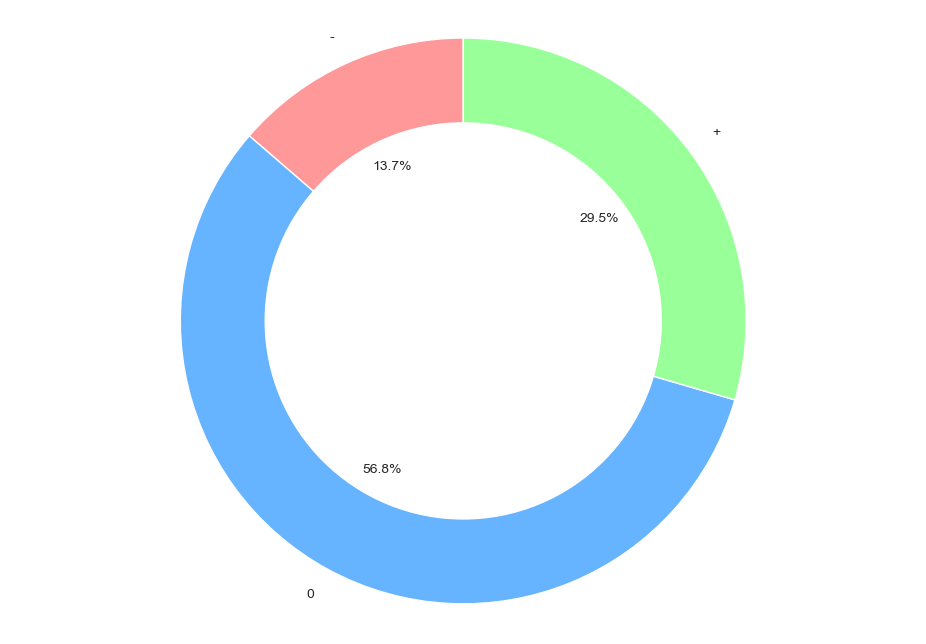

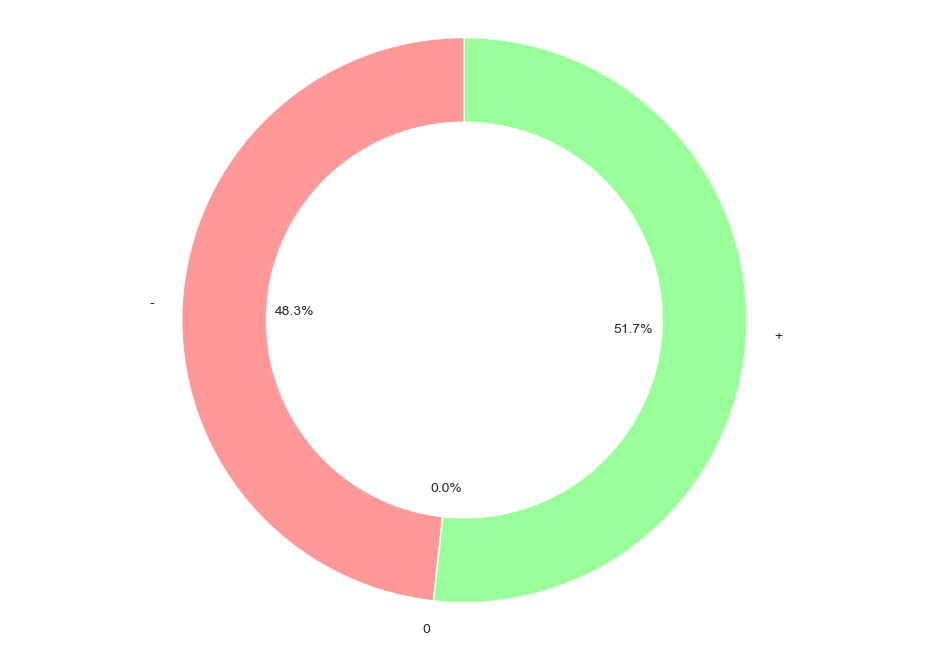

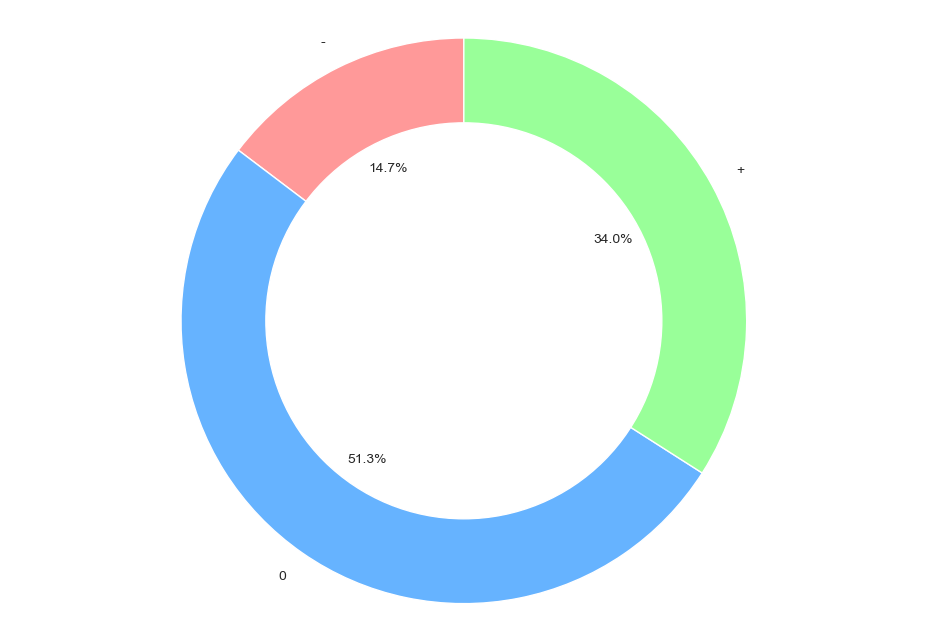

In [12]:
try:
    sent_metrics = [c for c in ['textblob.polarity'
                    , 'DistilBERT base uncased finetuned SST-2.sentiment'
                    , 'vader.compound'] if c in tweets_with_sent.columns]
    temp_sub_tab = [Output() for i in range(len(sent_metrics))]
    line_tab = Tab(temp_sub_tab)
    for i, met in enumerate(sent_metrics):
        line_tab.set_title(i,f"{met}")


        with temp_sub_tab[i]:   
          SentimentPieChart(met)

    display(line_tab)
except KeyError:
    pass

# remove histogram
#           if met ==  'vader.compound':
#             sns.displot(x = 'value'
#                         , data = tweets_with_sent[[c for c in tweets_with_sent.columns if 'vader' in c]].melt()
#                         , kind = 'kde'
#                         , hue = 'variable'
#                         )
#           else:
#               sns.displot(tweets_with_sent[met]
#                 , kind = 'kde')
#           plt.title(met)       
#           plt.show()

In [13]:
def CreateTagList(r,text, char, clean = True):
  out = []
  if char in r[text]:
    txt = r[text].split(' ')
    for c in txt:
      if len(c) > 0 and c[:len(char)] == char:
        if clean:
            out.append(c.replace(char,'').lower().translate(str.maketrans('', '', string.punctuation)))
        else:
            out.append(c)
  return out


def PlotAtandPound(df, col):
  temp = df[['id',col]].explode(col).groupby(col).agg({'id':'count'}).reset_index().sort_values(by='id',ascending=False)
  # who are they  the most
  sns.barplot(x = 'id'
            , y = col
            , data = temp.head(20)
            , color = colors_fore_blue)
  plt.title(f'Total {col} Count')
  plt.xlabel('')
  plt.show()
  display(temp.describe().T.style.format('{:.1f}'))

def PlotDropDownBar(col, year):
    def PlotByYear(year):
        if year == 'All':
            return PlotAtandPound(tweets_with_sent,col)
        else:
            return PlotAtandPound(tweets_with_sent.loc[tweets_with_sent['tweet_year'] == int(year)],col)
    display(interact(PlotByYear, year = ['All'] + [str(yr) for yr in tweets_with_sent['tweet_year'].unique()]
                    ,__output_result=False))


In [14]:
md('# Frequently @ twitter users')

# Frequently @ twitter users

In [15]:
tweets_with_sent['@s'] = tweets_with_sent.apply(lambda r: CreateTagList(r,'text','@'), axis = 1)
tweets_with_sent['#s'] = tweets_with_sent.apply(lambda r: CreateTagList(r,'text','#'), axis = 1)



tweets_with_sent['tweet_year'] = tweets_with_sent['tweet_date'].dt.year

In [16]:
def CreateTabs(col):
    years = ['All'] + [str(yr) for yr in tweets_with_sent['tweet_year'].unique()]
    temp_sub_tab = [Output() for i in range(len(years))]
    line_tab = Tab(temp_sub_tab)
    for i, year in enumerate(years):
        line_tab.set_title(i,f"{year}")
        with temp_sub_tab[i]:   
            if year == 'All':
                plot_df = tweets_with_sent.copy()
            else:
                plot_df = tweets_with_sent.loc[tweets_with_sent['tweet_year'] == int(year)].copy()
            PlotAtandPound(plot_df,col)

    display(line_tab)


In [17]:

# PlotAtandPound(tweets_with_sent,'@s')
# PlotDropDownBar('@s')
CreateTabs('@s')

In [18]:
md('# Hashtags')

# Hashtags

In [19]:

# PlotAtandPound(tweets_with_sent,'#s')
# PlotDropDownBar('#s')
CreateTabs('#s')

In [20]:
md('# Linked Websites')

# Linked Websites

In [21]:
# tweets_with_sent['urls'] = tweets_with_sent.apply(lambda r: CreateTagList(r,'text','https', clean = False), axis = 1)
# tweets_with_sent['urls'] = tweets_with_sent.apply(lambda r: [requests.get(u).url for u in r['urls']], axis = 1)

tweets_with_sent['links'] = tweets_with_sent.apply(lambda r: CreateTagList(r,'text','https'), axis = 1)


# PlotAtandPound(tweets_with_sent,'urls')
# PlotDropDownBar('links')
CreateTabs('links')

bovadaofficial


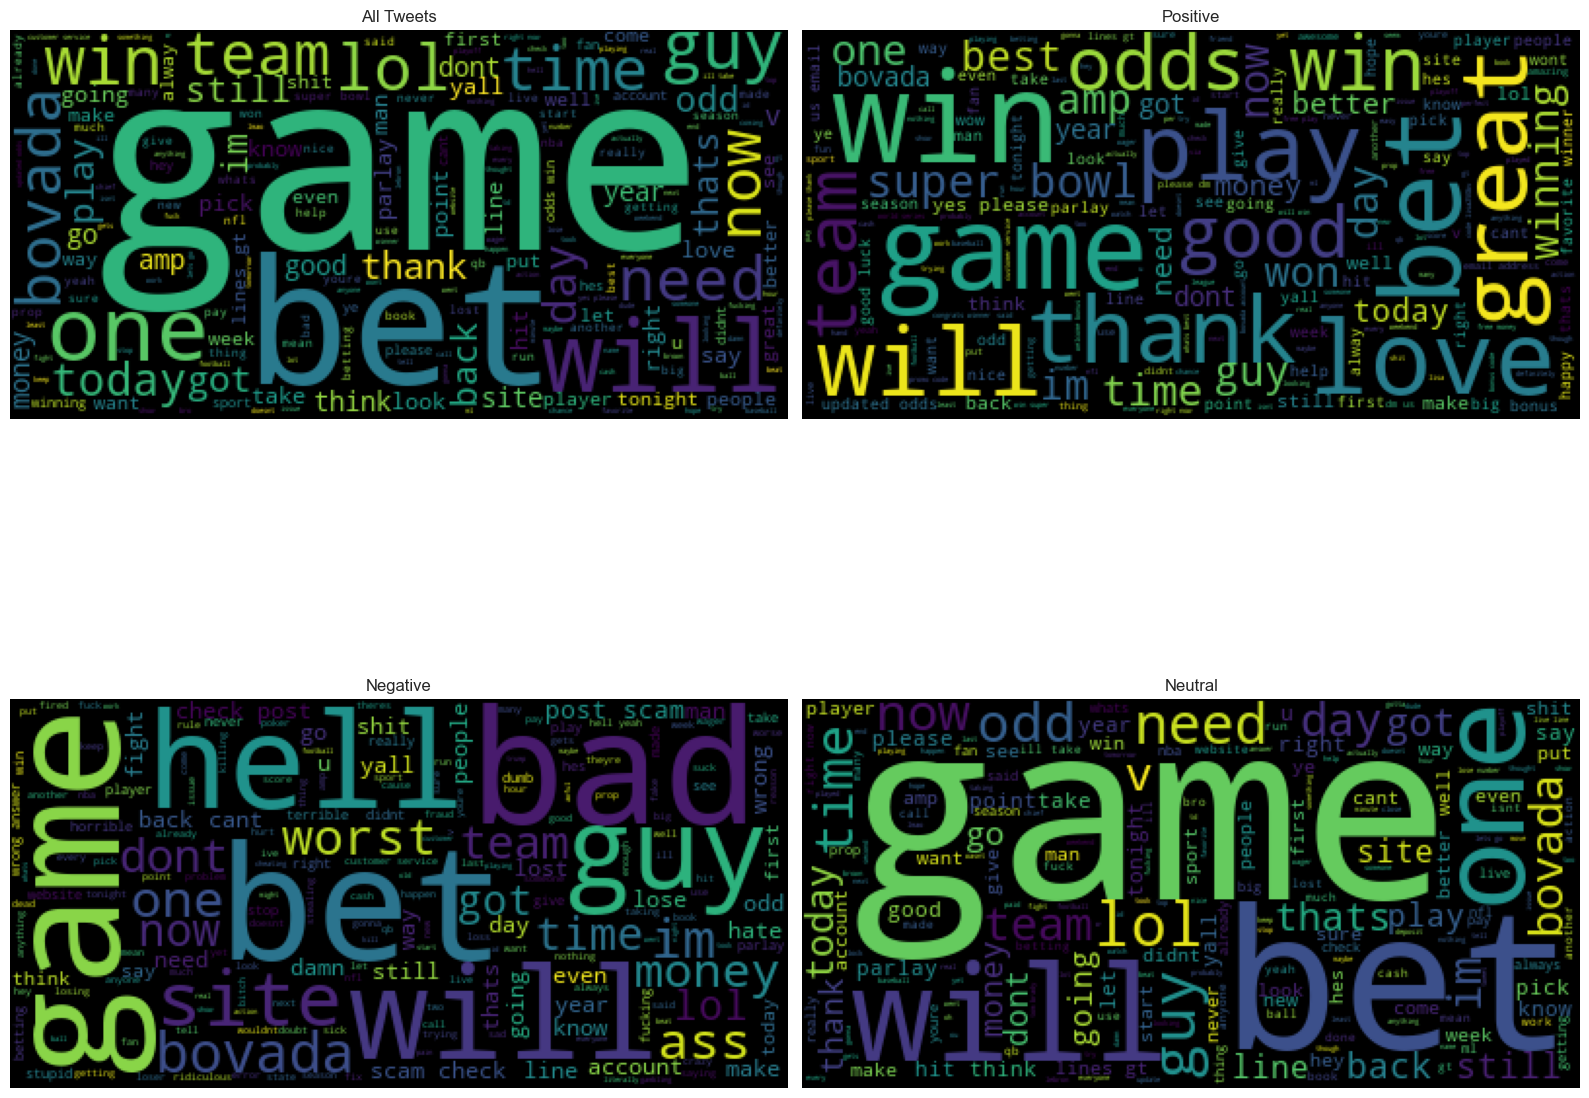

In [22]:
# Word Frequencies *****

stopwords = set(list(STOPWORDS)
               + ['https'
                  ,'https '
                  , 'co'
                  ,'com'
                  ,topic]
                + [t.lower() for t in topic.replace('from:','').replace('OR','').replace('AND', '').replace('(', '').replace(')', '').split(' ') if len(t) > 0])

tweets_with_sent['clean_text'] = tweets_with_sent['clean_text']\
                                    .apply(lambda x: ' '.join([word for word in x.split() if word not in stopwords]))


print(topic)

 
fig, axes = plt.subplots(nrows=2
                  , ncols=2
                  ,figsize=(16,16))
PlotWordCloud(tweets_with_sent['clean_text'],axes[0,0],'All Tweets')
try:
  PlotWordCloud(tweets_with_sent.loc[tweets_with_sent['vader.compound'] > .5]['clean_text'],axes[0,1],'Positive')
  PlotWordCloud(tweets_with_sent.loc[tweets_with_sent['vader.compound'] < -.5]['clean_text'],axes[1,0],'Negative')
  PlotWordCloud(tweets_with_sent.loc[(tweets_with_sent['vader.compound'] < .5)
                        &(tweets_with_sent['vader.compound'] > -.5)]['clean_text'],axes[1,1],'Neutral')
  fig.tight_layout()
  plt.show()
except:
  print('no sentiment')
  plt.show()

# display(line_tab)


- A word cloud is a collection, or cluster, of words depicted in different sizes. 
- The bigger and bolder the word appears, the more often it's mentioned within a given text 

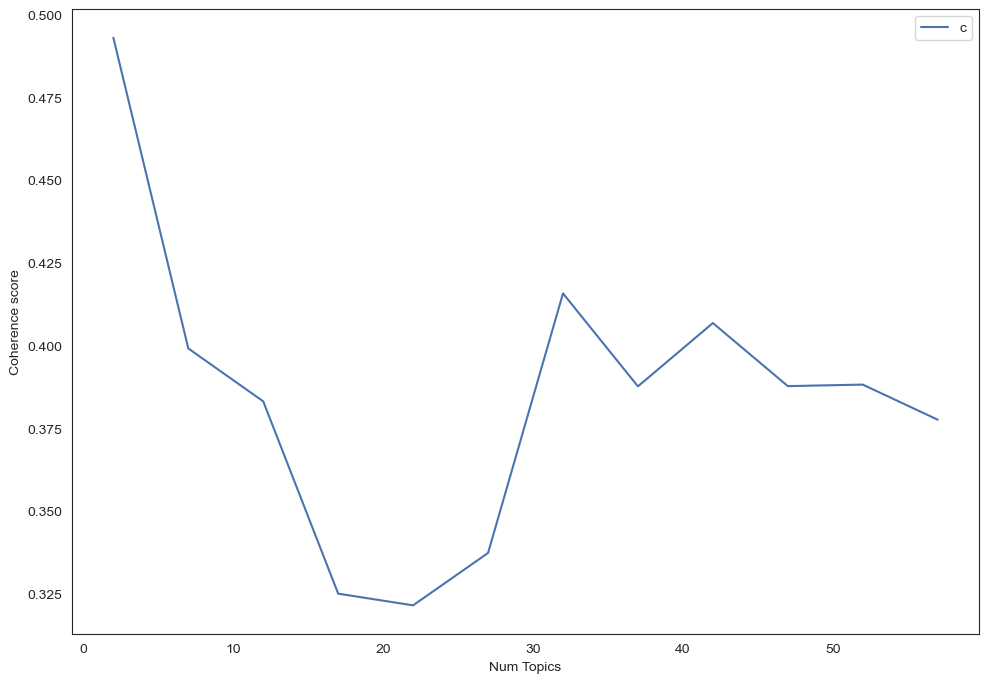

In [23]:
# Topic Modeling *****
limit = 60
start = 2
step = 5

#create dictionary
tweets = tweets_with_sent['clean_text'].values.tolist()
tweets = [t.split(' ') for t in tweets]

id2word = Dictionary(tweets)
# term document frequency
corpus = [id2word.doc2bow(text) for text in tweets]


model_list, coherence_values = compute_coherence_values(dictionary=id2word
                                                        , corpus=corpus
                                                        , texts=tweets
                                                        , start=start
                                                        , limit=limit
                                                        , step=step)

# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [24]:
best_result_index = coherence_values.index(max(coherence_values))
optimal_model = model_list[best_result_index]
# Select the model and print the topics
model_topics = optimal_model.show_topics(formatted=False)

#Creating Topic Distance Visualization 
pyLDAvis.enable_notebook()

vis = gensimvis.prepare(optimal_model
                        , corpus
                        , dictionary=optimal_model.id2word
                       , mds='mmds')
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.015129 -0.267002       1        1  69.720954
0      0.015129  0.267002       2        1  30.279046, topic_info=         Term         Freq        Total Category  logprob  loglift
2679  celtics  5549.000000  5549.000000  Default  30.0000  30.0000
167       win  4900.000000  4900.000000  Default  29.0000  29.0000
77       odds  3305.000000  3305.000000  Default  28.0000  28.0000
5566     heat  3231.000000  3231.000000  Default  27.0000  27.0000
380      site  9137.000000  9137.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
268      good  1717.390696  1961.974255   Topic2  -4.9076   1.0616
1896   double   900.821647  1212.252198   Topic2  -5.5529   0.8978
574      next   734.269786   907.058004   Topic2  -5.7573   0.9834
1663   posted   632.755278   702.645216   Topic2  -5.9061   1.0899
1261     hell   628.868900   704.135009   Topic2  -5.9122   1.0817

[108 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
10650      2  0.999452       7u
170        1  0.999854  account
170        2  0.000512  account
1474       2  0.997987    allen
826        1  0.001818  assists
...      ...       ...      ...
167        2  0.999674      win
168        1  0.001118    world
168        2  0.998652    world
1240       1  0.999899     yall
1240       2  0.000319     yall

[152 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [25]:
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.015129 -0.267002       1        1  69.720954
0      0.015129  0.267002       2        1  30.279046, topic_info=         Term         Freq        Total Category  logprob  loglift
2679  celtics  5549.000000  5549.000000  Default  30.0000  30.0000
167       win  4900.000000  4900.000000  Default  29.0000  29.0000
77       odds  3305.000000  3305.000000  Default  28.0000  28.0000
5566     heat  3231.000000  3231.000000  Default  27.0000  27.0000
380      site  9137.000000  9137.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
268      good  1717.390696  1961.974255   Topic2  -4.9076   1.0616
1896   double   900.821647  1212.252198   Topic2  -5.5529   0.8978
574      next   734.269786   907.058004   Topic2  -5.7573   0.9834
1663   posted   632.755278   702.645216   Topic2  -5.9061   1.0899
1261     hell   628.868900   704.135009   Topic2  -5.9122   1.0817

[108 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
10650      2  0.999452       7u
170        1  0.999854  account
170        2  0.000512  account
1474       2  0.997987    allen
826        1  0.001818  assists
...      ...       ...      ...
167        2  0.999674      win
168        1  0.001118    world
168        2  0.998652    world
1240       1  0.999899     yall
1240       2  0.000319     yall

[152 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])


- The further the bubbles are away from each other, the more different they are
- Each bubble represents a topic. The larger the bubble, the higher percentage of the number of tweets in the corpus is about that topic.
- Blue bars represent the overall frequency of each word in the corpus. If no topic is selected, the blue bars of the most frequently used words will be displayed.
- Red bars give the estimated number of times a given term was generated by a given topic. 

In [26]:
timeit(time.time() - start_time)

hours: 1.0	minutes: 24.0	seconds: 20.251


In [27]:
display(Javascript('IPython.notebook.save_checkpoint();'))

<IPython.core.display.Javascript object>

# bovadaofficial